In [1]:
import cv2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from data import data_1hour
from catalogs import theoretical_sky
from interactive import *
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from flow import Flow

%matplotlib widget

%load_ext autoreload
%autoreload 2

RuntimeError: 'widget is not a recognised GUI loop or backend name

In [2]:
image, psf, imwcs = data_1hour(0)

In [3]:
sky = theoretical_sky(imwcs, psf, catalog="VLSSR")

/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [4]:
# mask out artifacts outside of horizon
mask = (jnp.linalg.norm(indices(4096, 4096).reshape((4096 * 4096, 2)) - 4096//2, axis=1) < 0.85 * 4096 / 2).reshape((4096, 4096))

image = image * mask
sky = sky * mask

In [5]:
# bring the source image and theoretical sky to roughly the same brightness levels
%time sky = match_histograms(sky, image)

CPU times: user 2.17 s, sys: 129 ms, total: 2.3 s
Wall time: 4.2 s


In [6]:
# rescale image to [0, 1], taking (roughly) only positive flux information
image = rescale_quantile(image, 0.50, 0.99)
sky = rescale_quantile(sky, 0.50, 0.99)

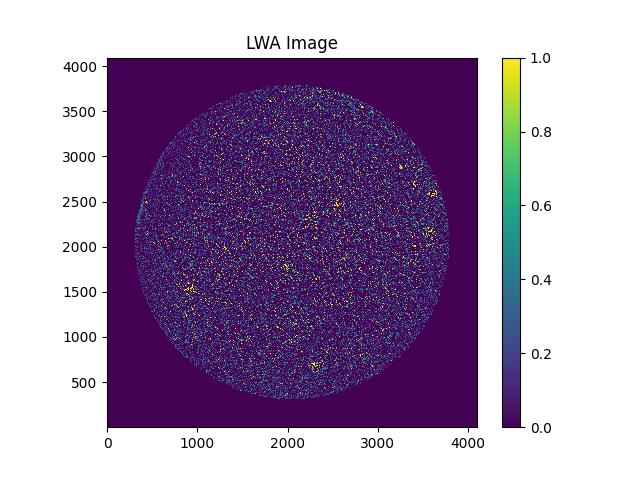

In [7]:
# press t to toggle between the two images
toggle_images(image, sky, vmax=1, title_1="LWA Image", title_2="Theoretical Sky")

In [8]:
# apply gaussian to input images for a smoother output
img1 = gaussian_filter(image, sigma=3)
img2 = gaussian_filter(sky, sigma=3)
flow = Flow.brox(img1, img2, alpha=1, gamma=150, scale_factor=0.7)

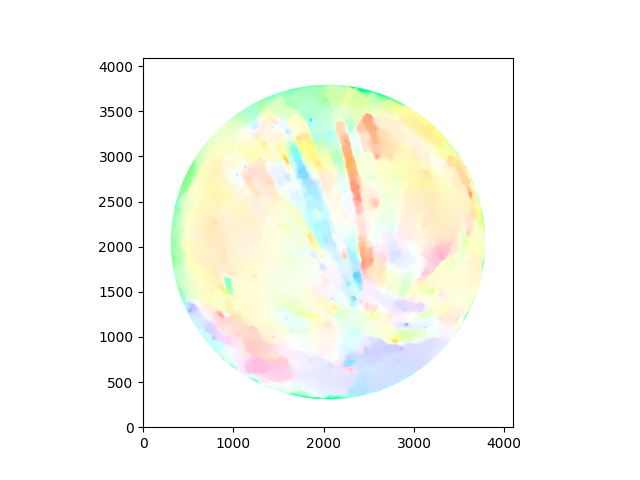

In [9]:
plt.close("rgb")
plt.figure("rgb")
plt.imshow(flow.to_rgb(mask), origin="lower")
plt.show()

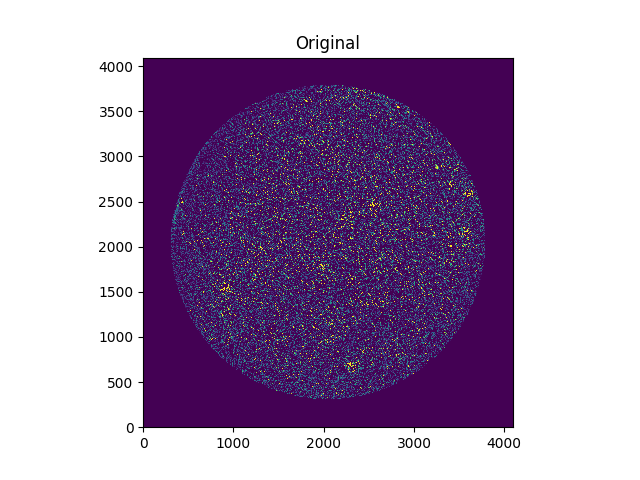

In [10]:
# press N and P to navigate to the next and previous images in the sequence, respectively.
sequence_images([image, flow.apply(image), sky], titles=["Original", "Dewarped", "Theoretical"])

In [11]:
# the average shifts over all pixels
jnp.mean(jnp.linalg.norm(flow.offsets.reshape((4096 * 4096, 2)), axis=-1))

Array(4.9744835, dtype=float32)

In [12]:
# Try repeatedly learning flow fields until convergence

T = 100  # max iterations

# initial image/flow
curr_image = img1
total_flow = Flow.zero(img1.shape)

for t in range(T):
    flow = Flow.brox(curr_image, img2, alpha=1, gamma=150, scale_factor=0.7)

    # accumulate new flow
    curr_image = flow.apply(curr_image)
    total_flow = total_flow.compose(flow)

    # loop until flow field is nearly zero
    score = jnp.mean(jnp.linalg.norm(flow.offsets.reshape((4096 * 4096, 2)), axis=-1))
    if t % 10 == 0:
        print(t, score)
    
    if score < 1:
        break

print(t, score)

0 4.9744835
10 3.1715271
20 2.9167533
30 2.7190342
40 2.539087
50 2.3695745
60 2.2021675
70 2.0230606
80 1.8454744
90 1.6709961
99 1.5023956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-32.806564..1.0].


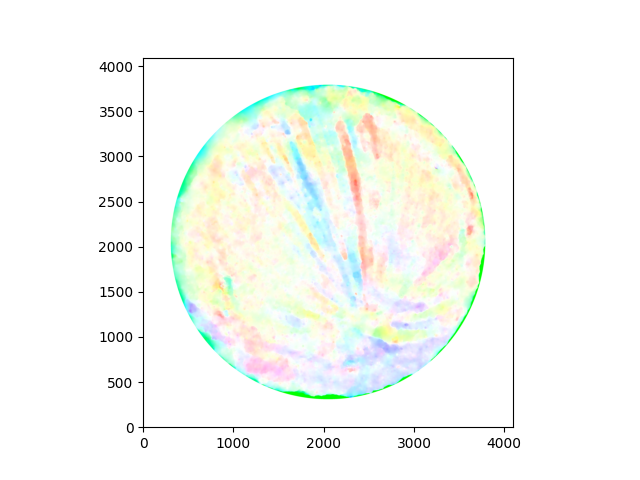

In [13]:
plt.close("rgb2")
plt.figure("rgb2")
plt.imshow(total_flow.to_rgb(mask, scale=15), origin="lower")
plt.show()

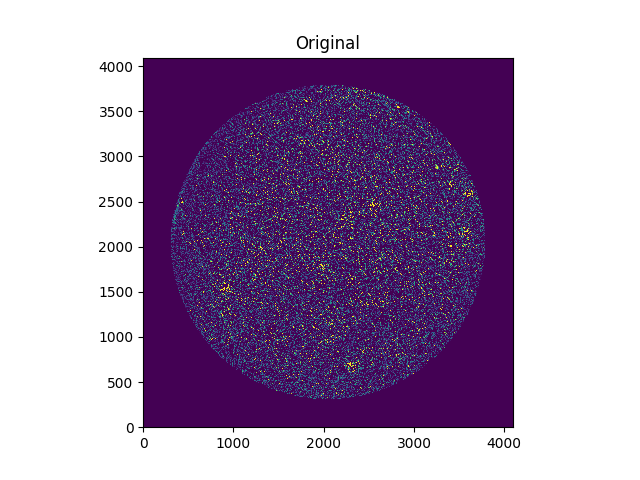

In [14]:
sequence_images([image, total_flow.apply(image), sky], titles=["Original", "Dewarped", "Theoretical"])